# **ArcFace: Additive Angular Margin Loss for Deep Face Recognition**

Deng, J., Guo, J., Xue, N., & Zafeiriou, S. (2019). Arcface: Additive angular margin loss for deep face recognition. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 4690-4699).

## **Reference**

*https://github.com/peteryuX/arcface-tf2*

*https://www.tensorflow.org/addons/tutorials/losses_triplet*

## **Default Setting**

In [22]:
import tensorflow as tf

import datetime
# import math
import os
import sklearn
import time

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%load_ext tensorboard

print(f"tf.__version__: {tf.__version__}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
tf.__version__: 2.4.1


In [2]:
!nvidia-smi

Fri Feb 19 04:40:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Model**

In [3]:
class ArcMarginPenaltyLogists(tf.keras.layers.Layer):

    def __init__(self, num_classes, margin = 0.5, feature_scale = 64):
        super(ArcMarginPenaltyLogists, self).__init__(name = "ArcMarginPenaltyLogists")
        self.num_classes   = num_classes
        self.margin        = margin
        self.feature_scale = feature_scale

    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "num_classes"  : self.num_classes,
            "margin"       : self.margin,
            "feature_scale": self.feature_scale})
        return config


    def build(self, input_shape):
        self.w = self.add_weight(shape = (input_shape[-1], self.num_classes),
                                 initializer = "glorot_uniform",
                                 trainable = True,
                                 name = "w")
        self.cos_m = tf.identity(tf.math.cos(self.margin), name = "cos_m")
        self.sin_m = tf.identity(tf.math.sin(self.margin), name = "sin_m")
        # self.th    = tf.identity(tf.math.cos(math.pi - self.margin))
        # self.mm    = tf.multiply(self.sin_m, self.margin)


    def call(self, features, labels):
        ## Algorithm 1: step 1 to 3.
        normed_features = tf.math.l2_normalize(features, axis = 1, name = "normed_features") ## (batch, 512)
        normed_w        = tf.math.l2_normalize(self.w, axis = 0, name = "normed_w")          ## (512, n)

        cos_t = tf.linalg.matmul(normed_features, normed_w, name = "cos_t")                  ## (batch, n)
        sin_t = tf.math.sqrt(1 - cos_t ** 2, name = "sin_t")


        ## Algorithm 1: step 4 to 6.

        ## Instead to calculate arccos, use the formula as below. 
        ##   cos(theta + m) = cos(theta)cos(m) - sin(theta)sin(m) (코는 코코신신)
        cos_mt = tf.subtract(cos_t * self.cos_m, sin_t - self.sin_m, name = "cos_mt")

        ## I don't understand why the formula below is needed.
        ## https://github.com/peteryuX/arcface-tf2/blob/8b4533bacbccf4982d2b44aeea5c38ed05173240/modules/layers.py#L42
        """
            cos_mt = tf.where(cos_t > self.th, cos_mt, cos_t - self.mm)
        """

        ## Algorithm 1: step 7 to 9.
        mask = tf.one_hot(tf.cast(labels, tf.dtypes.int32), depth = self.num_classes, name = "one_hot_mask")

        logists = tf.where(mask == 1., cos_mt, cos_t)
        logists = tf.math.multiply(logists, self.feature_scale, name = "arcface_logist")

        return logists

In [4]:
def BackboneModel(input_shape):
    """Return pre-trained MobileNet, or ResNet50 is also a good choice."""
    return tf.keras.applications.MobileNet(
        include_top = False, 
        weights = None, 
        input_shape = input_shape)
    

def ExtraLayers(dropout_rate = 0.5, embedding_dims = 512):
    """BN-Dropout-Flatten-FC-BN"""
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        ## This part is omitted from the paper.
        ## GlobalAveragePoolin2D() is also a good choice.
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(embedding_dims),
        tf.keras.layers.BatchNormalization()], name = "ExtraLayers")

In [5]:
## Normalised cropped face size.
IMAGE_SIZE = [112, 112, 3]

def create_NN(
    model_name,
    num_classes = 10, ## for mnist
    apply_archead = True,
):
    x = model_input = tf.keras.layers.Input(shape = IMAGE_SIZE, dtype = tf.dtypes.float32, name = "input")
    y = model_label = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.int32, name = "label")
    
    ## Well-defined pre-trained embedding model.
    x = BackboneModel(IMAGE_SIZE)(x)

    ## Extra structures.
    x = ExtraLayers()(x)

    if apply_archead:
        ## Algorithm 1: step 1 to 3.
        x = ArcMarginPenaltyLogists(num_classes)(x, y)
        
    model_output = tf.keras.layers.Softmax(name = "softmax")(x) ## important!!

    return tf.keras.Model(
        inputs = [model_input, model_label],
        outputs = model_output,
        name = model_name)

In [6]:
tmp = create_NN("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
mobilenet_1.00_112 (Functional) (None, 3, 3, 1024)   3228864     input[0][0]                      
__________________________________________________________________________________________________
ExtraLayers (Sequential)        (None, 512)          4725248     mobilenet_1.00_112[0][0]         
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
________________________________________________________________________________________________

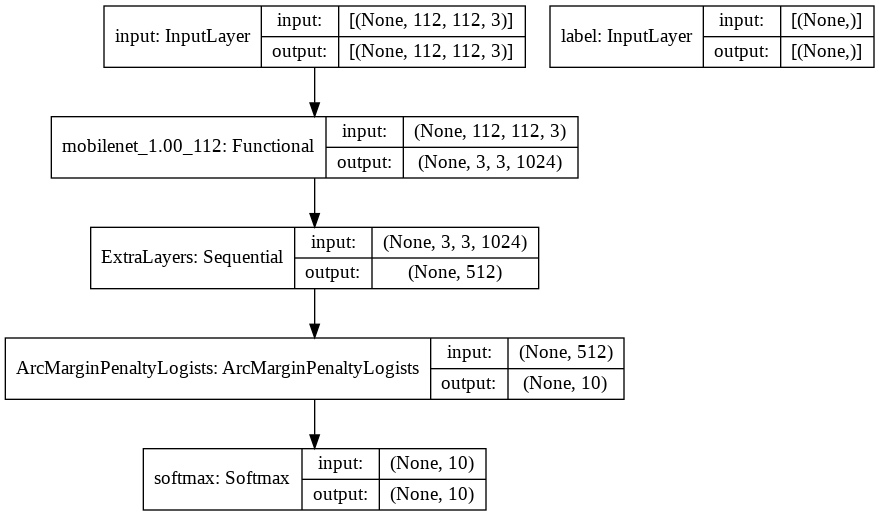

In [7]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [8]:
del tmp

## **Load MNIST Dataset**

In [9]:
## Load MNIST dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Print the shapes.
print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)
y_train.shape: (60000,)
x_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


In [10]:
@tf.function
def tr_rescale_and_resize(images, labels):
    images = tf.expand_dims(images, axis = -1)
    images = tf.image.convert_image_dtype(images, tf.dtypes.float32)
    images = tf.image.resize(images, [112, 112])
    images = tf.image.grayscale_to_rgb(images)
    labels = tf.cast(labels, tf.dtypes.int32)
    return (images, labels), labels

@tf.function
def ts_rescale_and_resize(images):
    images = tf.expand_dims(images, axis = -1)
    images = tf.image.convert_image_dtype(images, tf.dtypes.float32)
    images = tf.image.resize(images, [112, 112])
    images = tf.image.grayscale_to_rgb(images)
    return images

In [11]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE ## -1


## Train & test split.
NUM_TEST_SIZE = 10_000

tr_X, vl_X = x_train[NUM_TEST_SIZE:], x_train[:NUM_TEST_SIZE]
tr_Y, vl_Y = y_train[NUM_TEST_SIZE:], y_train[:NUM_TEST_SIZE]


## Make tf.data.Dataset.
tr_dataset = tf.data.Dataset.from_tensor_slices((tr_X, tr_Y)
                        ).batch(BATCH_SIZE
                        ).map(tr_rescale_and_resize, num_parallel_calls = AUTO
                        ).cache(
                        ).shuffle(3_000, reshuffle_each_iteration = True
                        ).prefetch(AUTO)

vl_dataset = tf.data.Dataset.from_tensor_slices((vl_X, vl_Y)
                        ).batch(BATCH_SIZE
                        ).map(tr_rescale_and_resize, num_parallel_calls = AUTO
                        ).cache(
                        # ).shuffle(3_000, reshuffle_each_iteration = True
                        ).prefetch(AUTO)

ts_dataset = tf.data.Dataset.from_tensor_slices((x_test,)
                        ).batch(BATCH_SIZE
                        ).map(ts_rescale_and_resize, # num_parallel_calls = AUTO
                        ).cache(
                        # ).shuffle(3_000, reshuffle_each_iteration = True
                        ).prefetch(AUTO)

## Print the shapes.
print(f"tr_dataset.element_spec: {tr_dataset.element_spec}")
print(f"vl_dataset.element_spec: {vl_dataset.element_spec}")
print(f"ts_dataset.element_spec: {ts_dataset.element_spec}")

tr_dataset.element_spec: ((TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
vl_dataset.element_spec: ((TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
ts_dataset.element_spec: TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None)


## **Compile and Train**

In [12]:
## Define a callback function that applies to each model.
def get_callbacks(
    model_name,
):
    ## Checkpoint callback.
    ckpt_path = os.path.join("ckpt", model_name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    os.makedirs(os.path.dirname(ckpt_path), exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    ## TensorBoard callback.
    log_dir = os.path.join("logs", "fit", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, update_freq = "batch")
    
    return [cp_callback, tb_callback]

In [13]:
## Create & compile.
## The optimizer has not been carefully chosen.
model_1 = create_NN("ArcFace")
model_1.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["acc"])

model_2 = create_NN("Softmax", apply_archead = False)
model_2.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["acc"])

In [26]:
# !rm -rf logs
# !rm -rf ckpt

In [14]:
%%time
## Fit the network with arcloss + softmax.
_ = model_1.fit(
    tr_dataset,
    validation_data = vl_dataset,
    verbose = 2,
    epochs = 10,
    callbacks = get_callbacks(model_1.name))

Epoch 1/10
782/782 - 52s - loss: 4.8012 - acc: 0.8321 - val_loss: 3.1418 - val_acc: 0.8774
Epoch 2/10
782/782 - 40s - loss: 0.6456 - acc: 0.9640 - val_loss: 0.6550 - val_acc: 0.9609
Epoch 3/10
782/782 - 41s - loss: 0.1837 - acc: 0.9858 - val_loss: 0.2226 - val_acc: 0.9898
Epoch 4/10
782/782 - 40s - loss: 0.0688 - acc: 0.9946 - val_loss: 0.1011 - val_acc: 0.9929
Epoch 5/10
782/782 - 40s - loss: 0.0431 - acc: 0.9956 - val_loss: 0.1022 - val_acc: 0.9940
Epoch 6/10
782/782 - 40s - loss: 0.0989 - acc: 0.9923 - val_loss: 0.2569 - val_acc: 0.9522
Epoch 7/10
782/782 - 40s - loss: 0.1937 - acc: 0.9894 - val_loss: 0.1503 - val_acc: 0.9925
Epoch 8/10
782/782 - 40s - loss: 0.1592 - acc: 0.9912 - val_loss: 0.0606 - val_acc: 0.9969
Epoch 9/10
782/782 - 40s - loss: 0.1628 - acc: 0.9910 - val_loss: 0.0834 - val_acc: 0.9953
Epoch 10/10
782/782 - 40s - loss: 0.1814 - acc: 0.9904 - val_loss: 0.0177 - val_acc: 0.9986
CPU times: user 5min 18s, sys: 2min 13s, total: 7min 31s
Wall time: 7min 3s


In [15]:
%%time
## Fit the network with only softmax.
_ = model_2.fit(
    tr_dataset,
    validation_data = vl_dataset,
    verbose = 2,
    epochs = 10,
    callbacks = get_callbacks(model_2.name))

Epoch 1/10
782/782 - 43s - loss: 2.0870 - acc: 0.9126 - val_loss: 0.7181 - val_acc: 0.9453
Epoch 2/10
782/782 - 40s - loss: 0.3915 - acc: 0.9842 - val_loss: 0.2255 - val_acc: 0.9818
Epoch 3/10
782/782 - 40s - loss: 0.1581 - acc: 0.9864 - val_loss: 0.3183 - val_acc: 0.9257
Epoch 4/10
782/782 - 40s - loss: 0.0925 - acc: 0.9888 - val_loss: 0.1424 - val_acc: 0.9703
Epoch 5/10
782/782 - 40s - loss: 0.0670 - acc: 0.9897 - val_loss: 0.0966 - val_acc: 0.9779
Epoch 6/10
782/782 - 40s - loss: 0.0542 - acc: 0.9899 - val_loss: 0.1016 - val_acc: 0.9771
Epoch 7/10
782/782 - 39s - loss: 0.0452 - acc: 0.9909 - val_loss: 0.0568 - val_acc: 0.9859
Epoch 8/10
782/782 - 40s - loss: 0.0391 - acc: 0.9910 - val_loss: 0.0549 - val_acc: 0.9857
Epoch 9/10
782/782 - 40s - loss: 0.0333 - acc: 0.9923 - val_loss: 0.0901 - val_acc: 0.9748
Epoch 10/10
782/782 - 40s - loss: 0.0316 - acc: 0.9921 - val_loss: 0.0430 - val_acc: 0.9891
CPU times: user 4min 58s, sys: 2min 6s, total: 7min 4s
Wall time: 6min 51s


## **Commit the Training & Validation Results**

In [ ]:
%tensorboard --logdir logs/fit/

In [ ]:
# !tensorboard dev upload --logdir ./logs \
#     --name "Simple experiment of ArcFace & Softmax with MNIST" \
#     --description "Training results from the paper 'Arcface: Additive angular margin loss for deep face recognition'" \
#     --one_shot

## **Embeding using t-SNE**

As mentioned in the paper, the loss **enforce intra-class compactness and inter-class discrepancy** on the hypershpere.

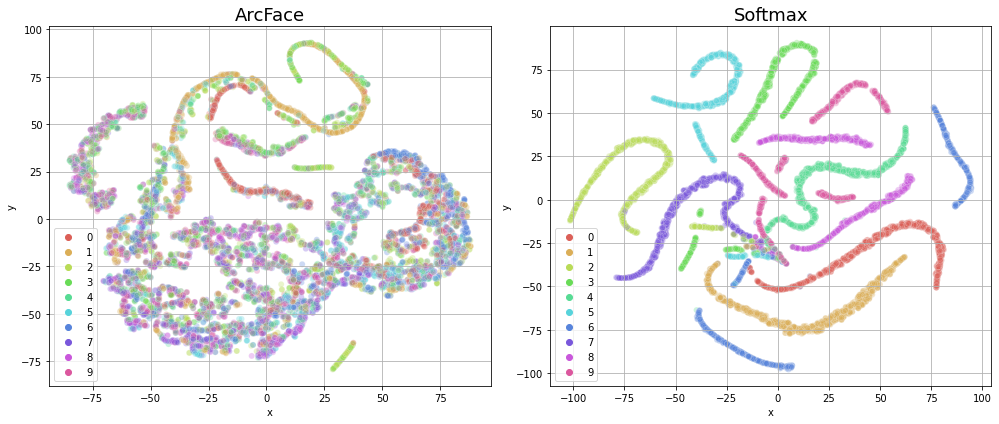

In [27]:
plt.figure(figsize = (14, 6), facecolor = "white")

for i, model in enumerate([model_1, model_2]):
    ## Extract feature values for the test dataset. Since the Embedding model 
    ## has a single input and output, the Training & Validation Dataset is 
    ## inappropriate to be used as an input to the model.
    embedding_model = tf.keras.Sequential(model.layers[:3]) ## Input ~ ExtraLayers

    embedding_vector = embedding_model.predict(ts_dataset) ## (10000, 512)
    # embedding_vector /= np.linalg.norm(embedding_vector, axis = 1, keepdims = True)

    np.savetxt(f"{model.name}_vecs.tsv", embedding_vector, delimiter = "\t")

    # print(f"embedding_vector.shape: {embedding_vector.shape}")

    ## Extract the metadata (i.e. labels).
    with open(f"{model.name}_meta.tsv", "w") as f:
        _ = [f.write(str(y) + "\n") for y in y_test]

    ## Calculate UMAP.
    rslt = TSNE(n_components = 2, perplexity = 30).fit_transform(embedding_vector)
    tSNE_dict = {"x": rslt[:, 0], "y": rslt[:, 1], "label": y_test}

    ## Plot it.
    plt.subplot(1, 2, i + 1)
    plt.title(model.name, fontsize = 18)
    sns.scatterplot(x = "x", y = "y", hue = "label",
                    palette = sns.color_palette("hls", 10),
                    data = tSNE_dict,
                    legend = True,
                    alpha = 0.3)

    plt.legend()
    plt.grid(True)
    # plt.axis("off")

plt.tight_layout()
plt.show()

In [20]:
## You can visualize the results in https://projector.tensorflow.org/.
try:
    from google.colab import files
    files.download("ArcFace_vecs.tsv")
    files.download("ArcFace_meta.tsv")
    files.download("Softmax_vecs.tsv")
    files.download("Softmax_meta.tsv")
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now, you can embeddings as below.

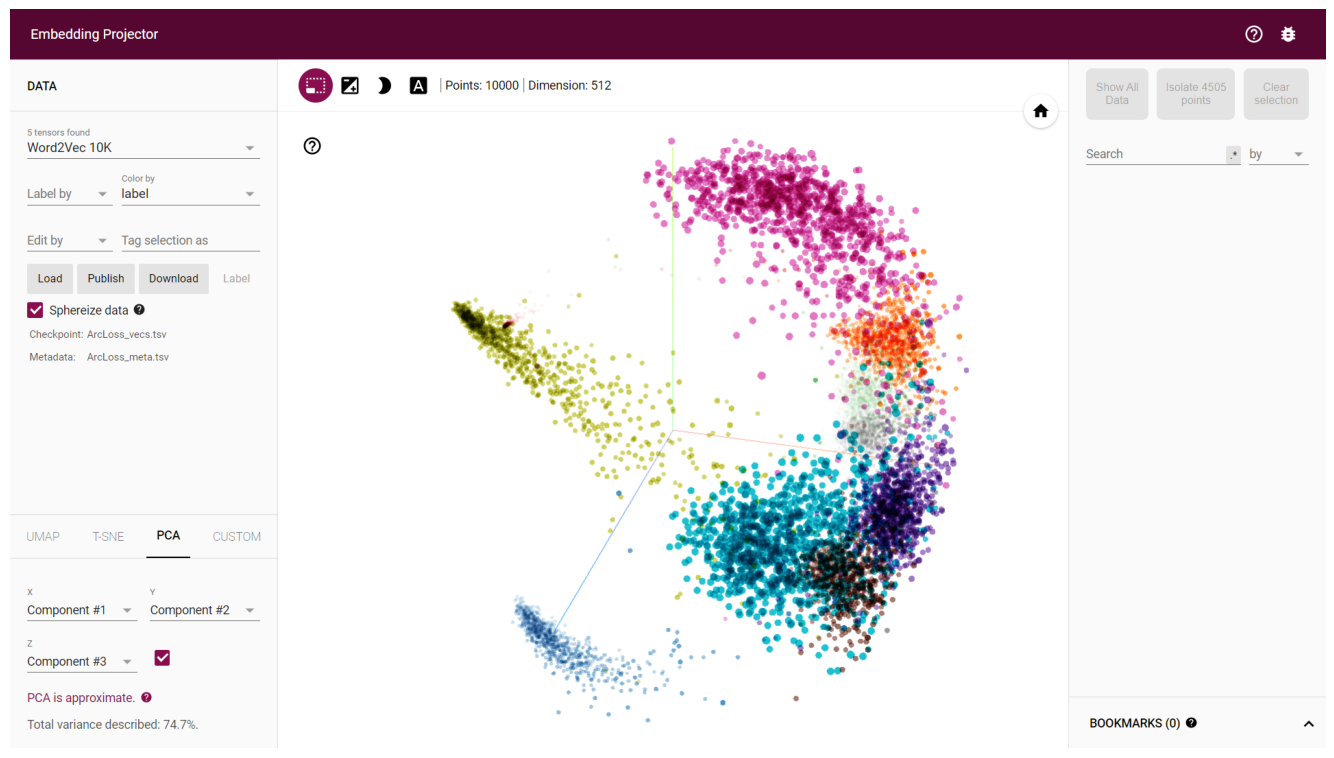

In [ ]:
## ArcFace
img = tf.image.decode_png(tf.io.read_file("arcface.png"))
plt.figure(figsize = (14, 8), dpi = 96)
plt.imshow(img)
plt.axis("off")
plt.tight_layout()
plt.show()

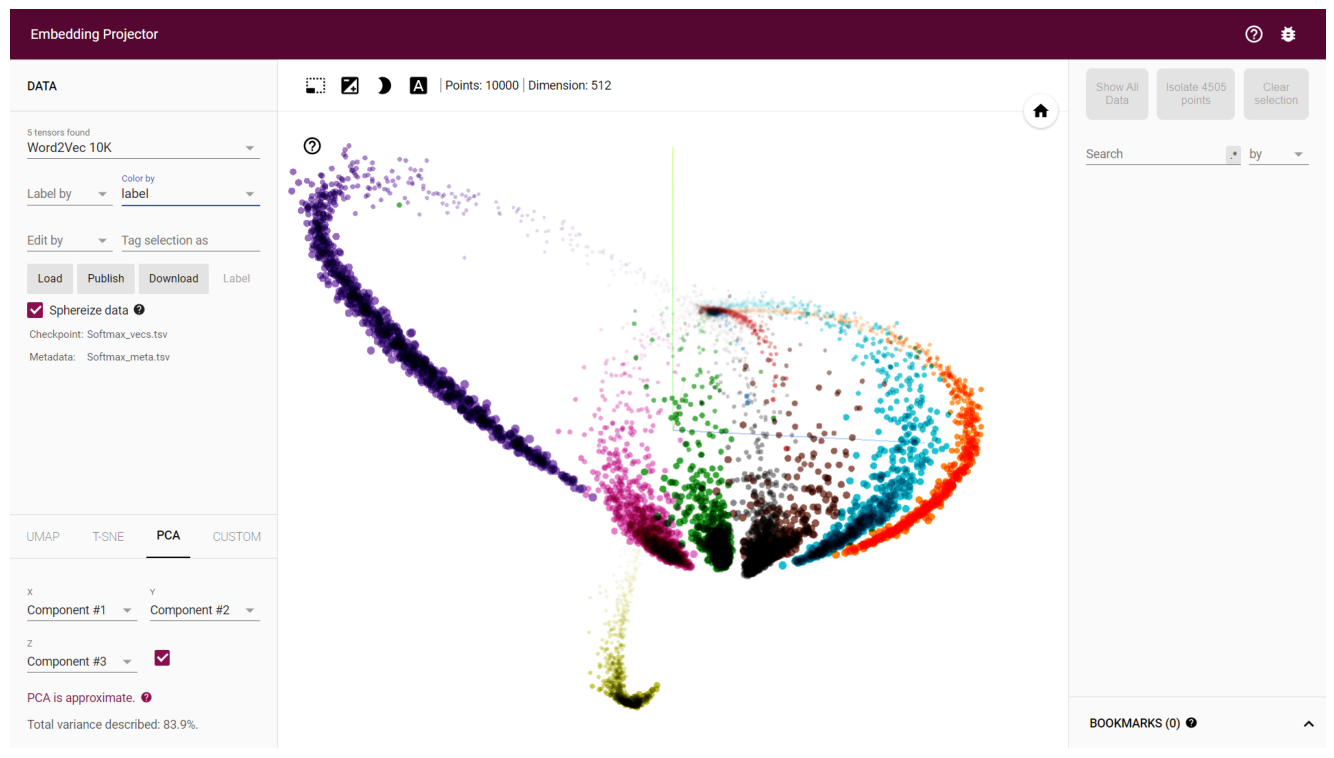

In [ ]:
## Softmax
img = tf.image.decode_png(tf.io.read_file("softmax.png"))
plt.figure(figsize = (14, 8), dpi = 96)
plt.imshow(img)
plt.axis("off")
plt.tight_layout()
plt.show()